# Truss Analyer Testing Zone

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import re
import math
import pandas as pd
from PyNite import FEModel3D
from PyNite.Visualization import render_model
from rich import print
import matplotlib.pyplot as plt
# import truss_input as ti
import truss_model as tm

In [14]:
def mem_properties() -> pd.DataFrame:
    """
    Import member properties from Canam, organize based on member type
    """
    mem_properties_df = pd.read_csv("OWSJ_member_properties_canam.csv", header = None)

    # create round bar df
    round_bar_df = mem_properties_df.iloc[0:11]
    round_bar_df.dropna(how='all', inplace=True, axis=1)
    round_bar_df = round_bar_df.loc[2:]
    round_bar_df.reset_index(inplace=True, drop=True)
    round_bar_df.columns = ["size (in)", "Forming", "Mass (kg/m)", "Area (mm2)", "I (1e3 mm4)", "r (mm)"]
    round_bar_df.index = round_bar_df["size (in)"]

    # create U-Bar df
    u_bar_df = mem_properties_df.iloc[12:29]
    u_bar_df.dropna(how='all', inplace=True, axis=1)
    u_bar_df = u_bar_df.iloc[3:]
    u_bar_df.reset_index(inplace=True, drop=True)
    u_bar_df["size"] = u_bar_df.loc[:,:5].apply(lambda row: ' '.join(row.astype(str)), axis=1) #combine the first 6 columns into 1
    u_bar_df = pd.merge(u_bar_df["size"], u_bar_df.loc[:,7:])
    u_bar_df.columns = ["size (in)", "Forming", "Mass (kg/m)", "Area (mm2)", "y (mm)", "Ixx (1e3 mm4)", "rxx (mm)", "Iyy (1e3 mm4)", "ryy (mm)"]
    u_bar_df.index = u_bar_df["size (in)"]
    

    # create double angle df
    dbl_angle_df = mem_properties_df.iloc[30:89]
    dbl_angle_df.dropna(how='all', inplace=True, axis=1)
    dbl_angle_df = dbl_angle_df.iloc[3:]
    dbl_angle_df.reset_index(inplace=True, drop=True)
    dbl_angle_df["size"] = dbl_angle_df.loc[:,:5].apply(lambda row: ' '.join(row.astype(str)), axis=1) #combine the first 6 columns into 1
    dbl_angle_df = pd.merge(dbl_angle_df["size"], dbl_angle_df.loc[:,7:])
    dbl_angle_df.columns = ["size (in)", "Forming", "Mass (kg/m)", "Area (mm2)", "y (mm)", "Ixx (1e3 mm4)", "rxx (mm)", "12.7 gap (mm)", "19 gap (mm)", "25 gap (mm)", "35 gap (mm)", "45 gap (mm)", "60 gap (mm)", "rz (mm)"]
    dbl_angle_df.index = dbl_angle_df["size (in)"]
    

    mem_dict = {"Round Bar": round_bar_df,
                "U-Bar": u_bar_df,
                "Double Angle": dbl_angle_df}
    
    return mem_dict

In [15]:
mem_dict = mem_properties()
mem_dict["Double Angle"]

C:\Users\Heidi Rey\AppData\Local\Temp\ipykernel_22504\1692309356.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_bar_df.dropna(how='all', inplace=True, axis=1)
C:\Users\Heidi Rey\AppData\Local\Temp\ipykernel_22504\1692309356.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_bar_df.dropna(how='all', inplace=True, axis=1)
C:\Users\Heidi Rey\AppData\Local\Temp\ipykernel_22504\1692309356.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

,size (in),Forming,Mass (kg/m),Area (mm2),y (mm),Ixx (1e3 mm4),rxx (mm),12.7 gap (mm),19 gap (mm),25 gap (mm),35 gap (mm),45 gap (mm),60 gap (mm),rz (mm)
size (in),,,,,,,,,,,,,,
1 x 1 x 1/8,1 x 1 x 1/8,Hot rolled,2.38,302,7.5,0.018,7.7,15.9,18.7,21.5,26.2,31.0,38.3,5.0
1 1/4 x 1 1/4 x 0.118,1 1/4 x 1 1/4 x 0.118,Cold formed,2.77,352,9.4,0.034,9.8,18.5,21.3,24.0,28.6,33.3,40.6,6.1
1 1/4 x 1 1/4 x 1/8,1 1/4 x 1 1/4 x 1/8,Hot rolled,3.00,383,9.1,0.037,9.8,18.3,21.0,23.7,28.3,33.1,40.3,6.2
1 1/4 x 1 1/4 x 3/16,1 1/4 x 1 1/4 x 3/16,Hot rolled,4.40,560,9.7,0.051,9.6,18.7,21.4,24.2,28.8,33.6,40.8,6.2
1 3/8 x 1 3/8 x 0.118,1 3/8 x 1 3/8 x 0.118,Cold formed,3.07,390,10.1,0.046,10.9,19.7,22.4,25.1,29.7,34.4,41.6,6.8
1 1/2 x 1 1/2 x 0.118,1 1/2 x 1 1/2 x 0.118,Cold formed,3.36,429,10.9,0.061,11.9,21.0,23.6,26.3,30.8,35.5,42.6,7.4
1 1/2 x 1 1/2 x 1/8,1 1/2 x 1 1/2 x 1/8,Hot rolled,3.66,464,10.7,0.065,11.8,20.7,23.4,26.0,30.6,35.2,42.4,7.5
1 1/2 x 1 1/2 x 5/32,1 1/2 x 1 1/2 x 5/32,Hot rolled,4.49,574,11.0,0.079,11.7,20.9,23.6,26.2,30.8,35.5,42.6,7.5
1 1/2 x 1 1/2 x 0.157,1 1/2 x 1 1/2 x 0.157,Cold formed,4.39,559,11.4,0.077,11.7,21.3,24.0,26.7,31.2,35.9,43.1,7.3


In [16]:
mem_sw= mem_properties()["Double Angle"]["Mass (kg/m)"]["1 x 1 x 1/8"]
mem_sw

C:\Users\Heidi Rey\AppData\Local\Temp\ipykernel_22504\1692309356.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_bar_df.dropna(how='all', inplace=True, axis=1)
C:\Users\Heidi Rey\AppData\Local\Temp\ipykernel_22504\1692309356.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_bar_df.dropna(how='all', inplace=True, axis=1)
C:\Users\Heidi Rey\AppData\Local\Temp\ipykernel_22504\1692309356.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

'2.38'

In [7]:
# # truss_type = "Warren"
# # truss_type = "Modified Warren"
# truss_type = "Pratt"
# n = 15
# L = 15000
# d = 1100
# f_load = 8

# top_nodes = []
# bot_nodes = []

# if truss_type == "Warren":
#     n_nodes_b = n/2
#     n_nodes_t = n_nodes_b + 1
#     dist_w_b = L/(n/2) #distance between bottom nodes
#     for i, loc in enumerate(list(np.linspace(0, L, int(n_nodes_t)))):
#         t_node = [loc, d]
#         top_nodes.append(t_node)
#         if i == 0:
#             continue
#         else: 
#             b_node = [loc-dist_w_b/2, 0] 
#             bot_nodes.append(b_node)

# elif truss_type == "Modified Warren":
#     n_nodes_b = n/3
#     n_nodes_t = 2*n_nodes_b + 1
#     for i, loc in enumerate(list(np.linspace(0, L, int(n_nodes_t)))):
#         t_node = [loc, d]
#         top_nodes.append(t_node)
#         if (i % 2 != 0): #add a bottom node for every even top node
#             b_node = [loc, 0] 
#             bot_nodes.append(b_node)

# else:
#     n_nodes_b = (n-1)/2
#     n_nodes_t = n_nodes_b + 2
#     for i, loc in enumerate(list(np.linspace(0, L, int(n_nodes_t)))):
#         t_node = [loc, d]
#         top_nodes.append(t_node)
#         if (i == 0) or (i == n_nodes_t-1):
#             continue
#         else: 
#             b_node = [loc, 0] 
#             bot_nodes.append(b_node)


+----------------+
| Statics Check: |
+----------------+

+------------------+--------+----------+----------+---------+--------+--------+--------+---------+--------+---------+--------+---------+
| Load Combination | Sum FX |  Sum RX  |  Sum FY  |  Sum RY | Sum FZ | Sum RZ | Sum MX | Sum RMX | Sum MY | Sum RMY | Sum MZ | Sum RMZ |
+------------------+--------+----------+----------+---------+--------+--------+--------+---------+--------+---------+--------+---------+
|        LC        |   0    | 8.73e-10 | -1.2e+05 | 1.2e+05 |   0    |   0    |   0    |    0    |   0    |    0    | -9e+08 |  9e+08  |
+------------------+--------+----------+----------+---------+--------+--------+--------+---------+--------+---------+--------+---------+



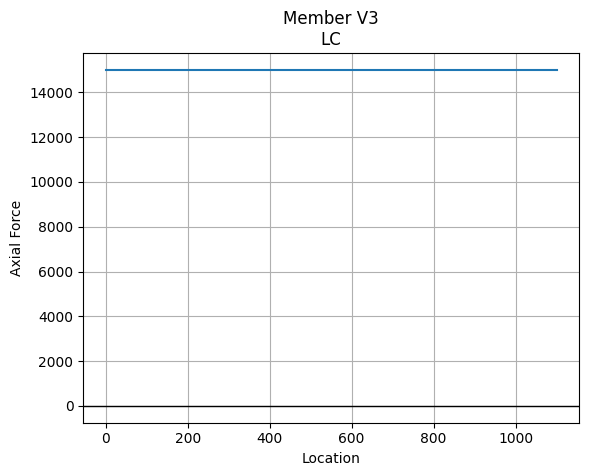

In [18]:
# truss = tm.truss_model(top_nodes, bot_nodes, truss_type, f_load)
# # render_model(truss, combo_name="LC", annotation_size=50, labels = False )
# render_model(truss, combo_name="LC", annotation_size=200)
# truss.analyze(check_statics=True)
# truss.Members['V3'].plot_axial(combo_name="LC", n_points=1000)

In [38]:
# axial_dict = {}
# for mem in truss.Members:
#     mem_mid = truss.Members[mem].L()/2
#     ax = truss.Members[mem].axial(mem_mid, combo_name="LC")
#     axial_dict[mem] = -int(ax/1000)
# axial_dict

{'TC': -206,
 'BC': 193,
 'WD0': 106,
 'WD1': 73,
 'WD2': 44,
 'WD3': 14,
 'WU3': 14,
 'WU4': 44,
 'WU5': 73,
 'WU6': 106,
 'V0': -53,
 'V1': -37,
 'V2': -22,
 'V3': -14,
 'V4': -22,
 'V5': -37,
 'V6': -53}

In [7]:
# # Import and clean Canam's tables

# def remove_comma(cell):
#     number = float(cell.replace(',', ''))
#     return number

# canam_df = pd.read_csv('OWSJ_tables_canam.csv',header=1)
# canam_df.rename(columns={canam_df.columns[0]: 'span', canam_df.columns[1]: 'depth'}, inplace=True)
# canam_df['span'].ffill(inplace=True)
# canam_df['span']= canam_df['span']*1000
# canam_df['depth'] = canam_df['depth'].apply(remove_comma)
# canam_df['depth'] = canam_df['depth'].astype(float)
# canam_df.head(10)

# # save as json for linux reading
# # canam_df.to_json('canam_df.json', orient='records')

In [8]:
# # Import Vulcraft's data
# vulcraft_df = pd.read_csv('OWSJ_tables_vulcraft.csv', header=1)
# vulcraft_df.rename(columns={"Factored Load": 'value'}, inplace=True)
# vulcraft_df.columns = [col.lower() for col in vulcraft_df]
# #drop first row and all bridging rows
# vulcraft_df.drop(index=0, inplace=True)
# vulcraft_df = vulcraft_df[~vulcraft_df['value'].str.contains('Bridg.')]
# #fill depths
# vulcraft_df['depth'].bfill(inplace=True)
# #convert all span values to mm
# vulcraft_df.span = vulcraft_df.span.astype(float)
# vulcraft_df.span = vulcraft_df.span*1000
# vulcraft_df.head(30)

# # save as json for linux reading
# # vulcraft_df.to_json('vulcraft_df.json', orient='records')

In [9]:
# # Import Omega's tables

# def find_span(cell):
#     if "SPAN" in cell:
#         match_span = re.search(r'\b(\d+)\b', cell)
#         return match_span.group(1)
#     else:
#         return np.nan

# omega_df = pd.read_csv('OWSJ_tables_omega.csv', header=None)
# col_names = ["depth", "D/D", "E/D", "E/E", "F/E", "F/F", "G/F", "G/G", "H/G", "H/H", "K/H", "K/K", "L/K", "L/L"]
# omega_df.columns = col_names
# omega_df['span'] = omega_df['depth'].apply(find_span)
# omega_df['span'].ffill(inplace=True)
# columns = ['span'] + [col for col in omega_df if col != 'span']
# omega_df = omega_df[columns]
# # Drop rows with useless info; cells with "DEPTH" OR "SPAN"
# omega_df = omega_df[~omega_df['depth'].str.contains('DEPTH') & ~omega_df['depth'].str.contains('SPAN')]

# # save as json for linux reading
# # omega_df.to_json('omega_df.json', orient='records')

In [10]:
# import tabula
# tables = tabula.read_pdf("metric tables from Vulcraft OWSJ.pdf", pages='all', multiple_tables=True, pandas_options={'header': None})

In [131]:
# # Start working with the saved dataframes for testing
# canam_df = pd.read_json("canam_df.json")
# omega_df = pd.read_json("omega_df.json")
# vulcraft_df = pd.read_json("vulcraft_df.json")
# canam_df.name = "canam"
# omega_df.name = "omega"
# vulcraft_df.name = "vulcraft"

# OWSJ_dfs = [canam_df, omega_df, vulcraft_df]

# span = 6000
# depth = 500
# f_load = 8

In [132]:
# #Run through each dataframe of tables and pull out the expected weight kg/m of joist used
# def find_adjacent_numbers(numbers, target):
#     """
#     Find numbers adjacent to target number for the sake of running interpolation
#     """
#     sorted_numbers = np.sort(numbers) # Sort the list of numbers
#     index = np.searchsorted(sorted_numbers, target) # Find the index of the target number
#     # Get the two numbers adjacent to the target number
#     if index == 0:
#         return sorted_numbers[0], sorted_numbers[0]
#     elif index == len(sorted_numbers):
#         return sorted_numbers[-1], sorted_numbers[-1]
#     else:
#         return sorted_numbers[index - 1], sorted_numbers[index]
        
# def isolate_sw(cell):
#     sw = float(cell.split("\n")[0])
#     return sw


# for df in OWSJ_dfs:
#     name = df.name
#     print(name)
#     span_mask = (df['span'] < 1.05*span) & (df['span'] > 0.95*span) 
#     depth_mask = (df['depth'] < 1.05*depth) & (df['depth'] > 0.95*depth)
#     df = df.loc[span_mask & depth_mask]
#     #Omega
#     if name == "omega":
#         cols = [col for col in df.columns if '/' in col]
#         df_sliced = df[cols]
#         chords = []
#         sws = []
#         for column in df_sliced.columns:
#             for index, cell_value in enumerate(df_sliced[column]):
#                 try:
#                     f = float(cell_value.split("\n")[0])
#                     sw = float(cell_value.split("\n")[2])
#                     if (f > 0.97*f_load) & (f < 1.03*f_load):
#                         chords.append((column, sw))
#                         sws.append(sw)
#                 except:
#                     continue
#         if sws == []:
#             expected_sw_omega = "no values found in that range"
#         else:
#             expected_sw_omega = np.mean(sws)
#     #Vulcraft         
#     elif name == "vulcraft":
#         df = df[df['value'].str.contains('Self')] #drop L/360 row
#         col_nums = [float(col) for col in df.columns if "." in col] #convert factored headers to float
#         adjacent_f_loads = find_adjacent_numbers(col_nums, f_load) #find interpolated, likely average self weight
#         df = df[[str(min(adjacent_f_loads)), str(max(adjacent_f_loads))]]
#         if adjacent_f_loads[1] == adjacent_f_loads[0]:
#             expected_sw_vulcraft = df[str(adjacent_f_loads[0])].values.mean()
#         else:
#             ratio = (f_load - min(adjacent_f_loads))/(abs(adjacent_f_loads[1] - adjacent_f_loads[0]))
#             df[str(f_load)] = (df[str(max(adjacent_f_loads))] - df[str(min(adjacent_f_loads))])*ratio + df[str(min(adjacent_f_loads))]
#             expected_sw_vulcraft = df[str(f_load)].values.mean()
#     #Canam
#     elif name == "canam":
#         col_nums = [float(col) for col in df.columns if "." in col] #convert factored headers to float
#         adjacent_f_loads = find_adjacent_numbers(col_nums, f_load) #find interpolated, likely average self weight
#         df = df[[str(min(adjacent_f_loads)), str(max(adjacent_f_loads))]]
#         df = df.map(isolate_sw)
#         if adjacent_f_loads[1] == adjacent_f_loads[0]:
#             expected_sw_canam = df[str(adjacent_f_loads[0])].values.mean()
#         else:
#             ratio = (f_load - min(adjacent_f_loads))/(abs(adjacent_f_loads[1] - adjacent_f_loads[0]))
#             df[str(f_load)] = (df[str(max(adjacent_f_loads))] - df[str(min(adjacent_f_loads))])*ratio + df[str(min(adjacent_f_loads))]
#             expected_sw_canam = df[str(f_load)].values.mean()

canam

omega

vulcraft